# 🧠 AN2DL 2024/25 Homework 2


## 🌐 Connect Colab to Google Drive

Google Drive connection for the owner of the Drive folder

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/DeepL/DeepL Team/Homework 2/Matteo

Mounted at /gdrive
/gdrive/My Drive/DeepL/DeepL Team/Homework 2/Matteo


Google Drive connection for other team members

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/DeepL Team/Homework 2/Elena

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1XqCxOkXIFV81NU8IlltS38bM65k9N-bR/DeepL Team/Homework 2/Elena


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
from datetime import datetime

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
np.random.seed(42)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.ndimage import sobel

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2.17.1
TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

### Data loading

In [ ]:
# Load image and label paths
print("Loading file paths ...")
image_paths = sorted([os.path.join('../Dataset/data', f) for f in os.listdir('../Dataset/data')])
label_paths = sorted([os.path.join('../Dataset/labels', f) for f in os.listdir('../Dataset/labels')])
print("File paths loaded!")

Loading file paths ...
File paths loaded!


In [ ]:
# Display some examples of paths
print("\nFirst 2 image paths:", image_paths[:2])
print("First 2 label paths:", label_paths[:2])


First 2 image paths: ['../Dataset/data/image_00000.png', '../Dataset/data/image_00001.png']
First 2 label paths: ['../Dataset/labels/label_00000.png', '../Dataset/labels/label_00001.png']


In [ ]:
category_map = {
        0: 0,  # Background
        1: 1,  # Soil
        2: 2,  # Bedrock
        3: 3,  # Sand
        4: 4,  # Big Rock
}

### Data splitting

In [ ]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data ...")
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    image_paths, label_paths, test_size=205, random_state=seed
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=300, random_state=seed
)
print("Data splitted!")

Splitting data ...
Data splitted!


In [ ]:
print(f"\nNumber of images ...")
print(f"Train     : {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test      : {len(test_img)}")


Number of images ...
Train     : 2000
Validation: 300
Test      : 205


In [ ]:
# Ratio of the splitting
print(f"Ratio of the splitting: {len(train_img)/len(image_paths)*100} / {len(val_img)/len(image_paths)*100} / {len(test_img)/len(image_paths)*100}")

Ratio of the splitting: 79.84031936127745 / 11.976047904191617 / 8.183632734530939


In [ ]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)  # Ensure 1 channel
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float16) / 255.0

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

In [ ]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

### Data inspection

In [ ]:
data = np.load("../Dataset/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape    : {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape    : (10022, 64, 128)


In [ ]:
'''print(f"Training mean    : {np.mean(X_train)}")
print(f"Test mean        : {np.mean(X_test)}")

print(f"\nTraining variance: {np.std(X_train)}")
print(f"Test variance    : {np.std(X_test)}")'''

'print(f"Training mean    : {np.mean(X_train)}")\nprint(f"Test mean        : {np.mean(X_test)}")\n\nprint(f"\nTraining variance: {np.std(X_train)}")\nprint(f"Test variance    : {np.std(X_test)}")'

The differences are small but measurable. This could imply that the test set underwent augmentations or preprocessing that slightly reduced brightness and contrast compared to the training set.

### Augmentation

In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    #Random horizontal and vertical flip.
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    # Random vertical flip
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    # Random horizontal flip
    flip_prob = tf.random.uniform([], seed=seed + 1)  # New seed for independence
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label


'@tf.function\ndef random_flip(image, label, seed=None):\n    #Random horizontal and vertical flip.\n    if seed is None:\n        seed = np.random.randint(0, 1000000)\n    flip_prob = tf.random.uniform([], seed=seed)\n    # Random vertical flip\n    image = tf.cond(\n        flip_prob > 0.5,\n        lambda: tf.image.flip_up_down(image),\n        lambda: image\n    )\n    label = tf.cond(\n        flip_prob > 0.5,\n        lambda: tf.image.flip_up_down(label),\n        lambda: label\n    )\n    # Random horizontal flip\n    flip_prob = tf.random.uniform([], seed=seed + 1)  # New seed for independence\n    image = tf.cond(\n        flip_prob > 0.5,\n        lambda: tf.image.flip_left_right(image),\n        lambda: image\n    )\n    label = tf.cond(\n        flip_prob > 0.5,\n        lambda: tf.image.flip_left_right(label),\n        lambda: label\n    )\n    return image, label\n'

### Create datasets

In [ ]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
          lambda x, y: tf_augment(x, y),
          num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

In [ ]:
# Create the datasets
print("Creating datasets ...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

Creating datasets ...
Datasets created!


In [ ]:
# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape : {input_shape}")
    print("Images shape:", images.shape)
    print("Images dtype:", images.dtype)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break


Input shape : (64, 128, 1)
Images shape: (64, 64, 128, 1)
Images dtype: <dtype: 'float32'>
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'uint8'>


In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(10, 2*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j], cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

Visualising examples from the training set:


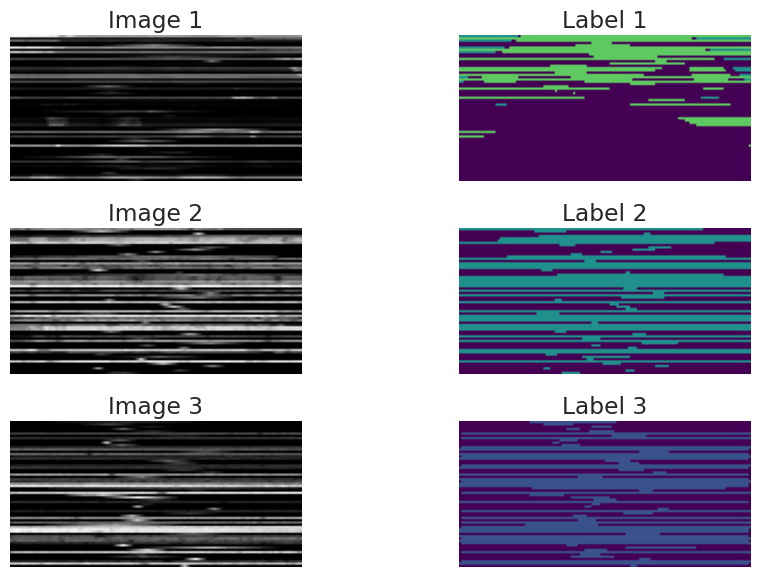

In [ ]:
# Visualize examples from the training set
print("Visualising examples from the training set:")
plot_sample_batch(train_dataset)

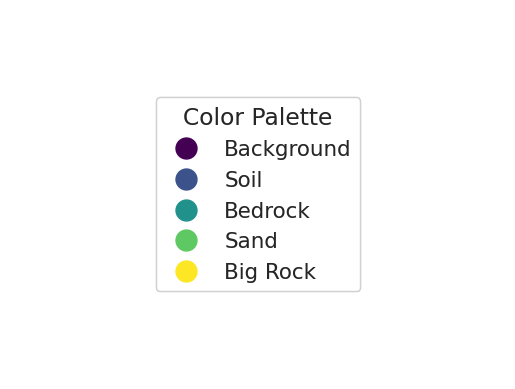

In [ ]:
num_classes = 5
# Create a discrete colormap using `viridis`
cmap = plt.cm.get_cmap('viridis', num_classes)

# Generate labels for the classes
class_labels = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']

# Create a scalar mappable to map colors to class indices
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.BoundaryNorm(boundaries=np.arange(num_classes + 1) - 0.5, ncolors=num_classes))

# Plot the legend
fig, ax = plt.subplots()
legend = ax.legend(
    handles=[plt.Line2D([0], [0], marker='o', color=cmap(i / num_classes), linestyle='', markersize=15) for i in range(num_classes)],
    labels=class_labels,
    loc='center',
    title="Color Palette"
)
ax.add_artist(legend)
ax.axis('off')  # No axis needed

plt.show()

## 🛠️ Train and Save the Model

In [ ]:
# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

### 🖌 Design of the model

# Advise 7: normalization
The idea is to:

Use different normalization techniques at different depths of the network.
Adapt the strategy based on the context:


* Shallow layers: May use Instance Normalization for robustness to variations in the data.

* Mid-layers: Could benefit from Group Normalization to balance efficiency and stability.
* Deeper layers: Could rely on Layer Normalization if channel equality or consistent scaling is important.


In [ ]:
#!pip install tensorflow-addons --upgrade --no-deps

In [ ]:
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import GroupNormalization

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name='',
              dropout_rate=0.0, normalization='batch', groups=8, regularizer_weight=1e-4):
  """
  UNet block with customizable normalization and regularization.

  Args:
      normalization: 'batch', 'instance', 'layer', or 'group'
      groups: Number of groups for Group Normalization (if used)
      regularizer_weight: Weight for L2 kernel regularization
  """
  x = input_tensor

  for i in range(stack):
      x = tfkl.Conv2D(
          filters,
          kernel_size=kernel_size,
          padding='same',
          #kernel_regularizer=tf.keras.regularizers.l2(regularizer_weight),
          name=name + 'conv' + str(i + 1)
      )(x)

      # Apply the selected normalization
      if normalization == 'batch':
          x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
      elif normalization == 'instance':
          # Mimics Instance Normalization
          x = GroupNormalization(groups=1, name=name + 'in' + str(i + 1))(x)
      elif normalization == 'layer':
          x = LayerNormalization(name=name + 'ln' + str(i + 1))(x)
      elif normalization == 'group':
          x = GroupNormalization(groups=groups, name=name + 'gn' + str(i + 1))(x)
      else:
          raise ValueError("Invalid normalization type. Choose from 'batch', 'instance', 'layer', 'group'.")

      x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

  if dropout_rate > 0.0:
      x = tfkl.Dropout(dropout_rate, name=name + 'dropout')(x)

  return x


In [ ]:
def cross_branch_attention(input_tensors, filters, name=''):
    # Concatenate features from different branches
    concatenated = tfkl.Concatenate(name=name + 'concat')(input_tensors)

    # Attention mechanism
    attention = tfkl.Conv2D(filters, kernel_size=1, activation='sigmoid', name=name + 'attention')(concatenated)

    # Apply attention to each branch
    scaled_tensors = [tfkl.Multiply(name=name + f'scale_branch{i}')([branch, attention])
                      for i, branch in enumerate(input_tensors)]

    # Sum the scaled branches
    fused_output = tfkl.Add(name=name + 'fuse')(scaled_tensors)

    return fused_output

In [ ]:
def global_context_module(input_tensor, filters, activation='relu', name=''):
    # Global average pooling
    global_context = tfkl.GlobalAveragePooling2D(name=name + 'gap')(input_tensor)
    global_context = tfkl.Dense(filters, activation='sigmoid', name=name + 'context_dense')(global_context)

    # Reshape and scale input tensor
    global_context = tfkl.Reshape((1, 1, filters), name=name + 'reshape')(global_context)
    scaled_input = tfkl.Multiply(name=name + 'scale')([input_tensor, global_context])

    return scaled_input

In [ ]:
def squeeze_and_excitation(input_tensor, reduction_ratio=16, name=''):
    filters = input_tensor.shape[-1]
    se = tfkl.GlobalAveragePooling2D(name=name + 'se_gap')(input_tensor)
    se = tfkl.Dense(filters // reduction_ratio, activation='relu', name=name + 'se_reduce')(se)
    se = tfkl.Dense(filters, activation='sigmoid', name=name + 'se_expand')(se)
    se = tfkl.Reshape((1, 1, filters), name=name + 'se_reshape')(se)

    # Scale the input tensor
    scaled_input = tfkl.Multiply(name=name + 'se_scale')([input_tensor, se])
    return scaled_input

In [ ]:
def pyramid_pooling_module(input_tensor, pool_sizes, filters, name):
      h, w = input_tensor.shape[1:3]  # Original spatial dimensions
      pooled_outputs = []

      for i, pool_size in enumerate(pool_sizes):
         # Skip invalid pooling sizes
          if h < pool_size or w < pool_size:
              continue

          # Pool and transform
          pooled = tfkl.AveragePooling2D(pool_size, strides=pool_size, name=name + f"_pool{i}")(input_tensor)
          pooled = tfkl.Conv2D(filters // len(pool_sizes), kernel_size=1, padding='same', name=name + f"_conv{i}")(pooled)

          # Resize to match original spatial dimensions
          resized = tfkl.Resizing(h, w, interpolation="bilinear", name=name + f"_resize{i}")(pooled)
          pooled_outputs.append(resized)

      # Fallback if no valid pooling operations
      if not pooled_outputs:
          return tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + "_fallback")(input_tensor)

      # Concatenate all outputs with the input tensor
      concatenated = tfkl.Concatenate(name=name + "_concat")(pooled_outputs + [input_tensor])
      return tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + "_final_conv")(concatenated)

In [ ]:
def advanced_bottleneck_with_residual(input_tensor, filters, name=''):
    # Parallel dilated convolutions
    branch1 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=1, padding='same', name=name + 'dilated1')(input_tensor)
    branch2 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=2, padding='same', name=name + 'dilated2')(input_tensor)
    branch3 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=3, padding='same', name=name + 'dilated3')(input_tensor)

    # Multi-Scale Fusion (combine features from branches)
    multi_scale_fusion = tfkl.Concatenate(name=name + 'multi_scale_concat')([branch1, branch2, branch3])
    fused_features = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'fused_features')(multi_scale_fusion)

    # Cross-branch attention
    attention_output = cross_branch_attention([branch1, branch2, branch3], filters, name=name + 'cross_attention')

    context_output = pyramid_pooling_module(attention_output, pool_sizes=[1, 2, 4, 8], filters=filters,
                                            name=name + 'pyramid_pooling')

    # Squeeze-and-Excitation
    enhanced_features = squeeze_and_excitation(context_output, name=name + 'se')

    # Residual connection: ensure input matches the output shape using a 1x1 convolution
    input_residual = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'conv_residual')(input_tensor)

    # Add residual connection
    output = tfkl.Add(name=name + 'residual_add')([input_residual, enhanced_features])

    return output

In [ ]:
def self_attention_block(input_tensor, name="self_attention"):
    channels = input_tensor.shape[-1]

    # Query, Key, and Value transformations
    query = tfkl.Conv2D(channels // 8, kernel_size=1, name=name + '_query')(input_tensor)
    key = tfkl.Conv2D(channels // 8, kernel_size=1, name=name + '_key')(input_tensor)
    value = tfkl.Conv2D(channels, kernel_size=1, name=name + '_value')(input_tensor)

    # Compute attention scores
    attention_scores = tfkl.Add(name=name + '_dot')([query, key])
    attention_scores = tfkl.Activation('softmax', name=name + '_softmax')(attention_scores)

    # Adjust attention scores shape to match `value`
    attention_scores = tfkl.Conv2D(channels, kernel_size=1, name=name + '_adjust')(attention_scores)

    # Apply attention
    attention = tfkl.Multiply(name=name + '_attention')([attention_scores, value])

    # Add residual connection
    return tfkl.Add(name=name + '_add')([input_tensor, attention])

In [ ]:
def gating_mechanism(encoder_features, decoder_features, filters, name=""):
    """
    Gating mechanism for skip connections in U-Net.
    Args:
        encoder_features: Feature map from encoder path.
        decoder_features: Feature map from decoder path.
        filters: Number of filters in the feature maps.
        name: Name prefix for layers.
    Returns:
        Gated fusion of encoder and decoder features.
    """
    #encoder_features = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + "encoder_align")(encoder_features)
    decoder_features = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + "decoder_align")(decoder_features)

    # Concatenate encoder and decoder features
    concatenated = tfkl.Concatenate(name=name + "concat")([encoder_features, decoder_features])

    # Generate gating map
    gate = tfkl.Conv2D(filters, kernel_size=1, activation='sigmoid', name=name + "gate")(concatenated)

    # Apply gating map to encoder and decoder features
    gated_features = tfkl.Add(name=name + "gated_add")([
        gate * encoder_features,
        (1 - gate) * decoder_features
    ])

    return gated_features

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense

def transformer_block(inputs, num_heads=4, key_dim=64, ff_dim=128, dropout_rate=0.1, name="transformer"):
    """
    Implements a Transformer encoder block.
    """
    # Multi-Head Self-Attention with Add & Norm
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, name=f"{name}_mha")(inputs, inputs)
    attention_output = tf.keras.layers.Add(name=f"{name}_add1")([inputs, attention_output])
    attention_output = LayerNormalization(name=f"{name}_ln1")(attention_output)

    # Feed-Forward Network with Add & Norm
    ff_output = Dense(ff_dim, activation="relu", name=f"{name}_ffn_dense")(attention_output)
    ff_output = Dense(inputs.shape[-1], name=f"{name}_ffn_output")(ff_output)
    ff_output = tf.keras.layers.Add(name=f"{name}_add2")([attention_output, ff_output])
    ff_output = LayerNormalization(name=f"{name}_ln2")(ff_output)

    return ff_output


In [ ]:
def adaptive_feature_fusion(encoder_features, decoder_features, filters, name):
    """
    Perform adaptive fusion of encoder and decoder features with trainable gates.
    """
    # Encoder path projection
    encoder_proj = tfkl.Conv2D(filters, kernel_size=1, padding="same", name=name + "_encoder_proj")(encoder_features)

    # Decoder path projection
    decoder_proj = tfkl.Conv2D(filters, kernel_size=1, padding="same", name=name + "_decoder_proj")(decoder_features)

    # Compute adaptive weights using a shared gating mechanism
    concat_proj = tfkl.Concatenate(name=name + "_concat_proj")([encoder_proj, decoder_proj])
    gates = tfkl.GlobalAveragePooling2D(name=name + "_gap")(concat_proj)
    gates = tfkl.Dense(filters // 4, activation="relu", name=name + "_dense1")(gates)
    gates = tfkl.Dense(2, activation="softmax", name=name + "_gates")(gates)

    # Split gates into alpha (encoder) and beta (decoder) using Lambda
    alpha = tfkl.Lambda(lambda x: x[:, 0:1], name=name + "_alpha")(gates)
    beta = tfkl.Lambda(lambda x: x[:, 1:2], name=name + "_beta")(gates)
    alpha = tfkl.Reshape((1, 1, 1))(alpha)
    beta = tfkl.Reshape((1, 1, 1))(beta)

    # Fuse features using adaptive weighted summation
    fused = tfkl.Add()([alpha * encoder_proj, beta * decoder_proj])

    return fused


In [ ]:
def get_unet_model_with_supervision(input_shape=(64, 128, 1), num_classes=5, seed=42, name_prefix=""):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name=name_prefix + 'input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name=name_prefix + 'down_block1_', normalization='batch')
    down_block_1 = self_attention_block(down_block_1, name=name_prefix + "self_attention1")
    d1 = tfkl.MaxPooling2D(name=name_prefix + 'maxpool1')(down_block_1)

    down_block_2 = unet_block(d1, 64, name=name_prefix + 'down_block2_', dropout_rate=0.1, normalization='batch')
    down_block_2 = self_attention_block(down_block_2, name=name_prefix + "self_attention2")
    d2 = tfkl.MaxPooling2D(name=name_prefix + 'maxpool2')(down_block_2)

    down_block_3 = unet_block(d2, 128, name=name_prefix + 'down_block3_', dropout_rate=0.2, normalization='batch')
    down_block_3 = self_attention_block(down_block_3, name=name_prefix + "self_attention3")
    d3 = tfkl.MaxPooling2D(name=name_prefix + 'maxpool3')(down_block_3)

    # Bottleneck with Transformer Block
    bottleneck = advanced_bottleneck_with_residual(d3, 256, name=name_prefix + 'bottleneck')
    bottleneck = transformer_block(bottleneck, num_heads=4, key_dim=64, ff_dim=256, name=name_prefix + "transformer")

    # Adaptive feature fusion in the first upsampling block
    u1 = tfkl.UpSampling2D(name=name_prefix + 'upsample1')(bottleneck)
    u1 = adaptive_feature_fusion(down_block_3, u1, filters=128, name=name_prefix + "adaptive_fusion1")
    u1 = unet_block(u1, 128, name=name_prefix + 'up_block1_', dropout_rate=0.1, normalization='group', groups=8)
    aux_output1 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax",
                          name=name_prefix + 'aux_output1')(u1)

    # Continue similarly for subsequent layers
    u2 = tfkl.UpSampling2D(name=name_prefix + 'upsample2')(u1)
    u2 = adaptive_feature_fusion(down_block_2, u2, filters=64, name=name_prefix + "adaptive_fusion2")
    u2 = unet_block(u2, 64, name=name_prefix + 'up_block2_', dropout_rate=0.2, normalization='group', groups=8)
    aux_output2 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax",
                          name=name_prefix + 'aux_output2')(u2)

    u3 = tfkl.UpSampling2D(name=name_prefix + 'upsample3')(u2)
    u3 = adaptive_feature_fusion(down_block_1, u3, filters=32, name=name_prefix + "adaptive_fusion3")
    u3 = unet_block(u3, 32, name=name_prefix + 'up_block3_', normalization='group', groups=8)

    # Main Output Layer
    main_output = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax",
                              name=name_prefix + 'output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=[main_output, aux_output1, aux_output2],
                            name=name_prefix + 'UNet_AdaptiveFusion')
    return model

In [ ]:
def get_dual_unet_model_with_supervision(input_shape=(64, 128, 1), num_classes=5, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")
    # High-Level U-Net for coarse features (with auxiliary outputs)
    def coarse_unet_with_supervision(input_tensor, downscale_factor=2):
        scaled_input = tfkl.Resizing(
            input_shape[0] // downscale_factor,
            input_shape[1] // downscale_factor,
            interpolation="bilinear",
            name="coarse_resizing"
        )(input_tensor)
        unet_coarse = get_unet_model_with_supervision(
            input_shape=(input_shape[0] // downscale_factor, input_shape[1] // downscale_factor, 1),
            num_classes=num_classes,
            seed=seed,
            name_prefix="coarse_"
        )

        coarse_outputs = unet_coarse(scaled_input)

        return coarse_outputs  # List of [main_output, aux_output1, aux_output2]

    coarse_outputs = coarse_unet_with_supervision(input_layer)
    # Low-Level U-Net for fine features (with auxiliary outputs)
    fine_unet = get_unet_model_with_supervision(
        input_shape=input_shape,
        num_classes=num_classes,
        seed=seed,
        name_prefix="fine_"
    )

    fine_outputs = fine_unet(input_layer)  # List of [main_output, aux_output1, aux_output2]
    # Feature Fusion
    # Upscale the coarse main output back to original resolution and combine
    coarse_main_output = coarse_outputs[0]  # Main output of coarse U-Net
    upscaled_coarse = tfkl.Resizing(
      input_shape[0], input_shape[1], interpolation="bilinear", name="coarse_upsampling"
    )(coarse_main_output)

    # Adaptive Feature Fusion for Coarse and Fine Outputs
    fused_coarse_fine = adaptive_feature_fusion(upscaled_coarse, fine_outputs[0], filters=num_classes, name="coarse_fine_fusion")

    # Use the fused output for refinement
    refined_output = tfkl.Conv2D(num_classes, kernel_size=3, padding='same', activation='relu', name='refine_conv')(fused_coarse_fine)
    final_output = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation='softmax', name='final_output')(refined_output)


    coarse_outputs[0] = tfkl.Resizing(
        input_shape[0], input_shape[1], interpolation="bilinear", name="coarse_upsampling0"
    )(coarse_outputs[0])
    coarse_outputs[1] = tfkl.Resizing(
        input_shape[0], input_shape[1], interpolation="bilinear", name="coarse_upsampling1"
    )(coarse_outputs[1])
    coarse_outputs[2] = tfkl.Resizing(
        input_shape[0], input_shape[1], interpolation="bilinear", name="coarse_upsampling2"
    )(coarse_outputs[2])

    # Model with multiple outputs
    model = tf.keras.Model(
        inputs=input_layer,
        outputs=[
            final_output,         # Final refined output
            *coarse_outputs[0:],  # Coarse U-Net outputs
            *fine_outputs[0:]     # Fine U-Net outputs
        ],
        name="Dual_UNet_Supervised"
    )

    return model

### 📸 Model summary

Model: "Dual_UNet_Supervised"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ coarse_resizing        │ (None, 32, 64, 1)    │            0 │ input_layer[0][0]   │    -    │
│ (Resizing)             │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ coarse_UNet_AdaptiveF… │ [(None, 32, 64, 5),  │    2,467,653 │ coarse_resizing[0]… │    Y    │
│ (Functional)           │ (None, 8, 16, 5),    │              │                     │         │
│                        │ (None, 16, 32, 5)]   │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 1)    │            0 │ -                   │    -    │
│ coarse_input_layer     │                      │              │                     │         │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │          320 │ -                   │    Y    │
│ coarse_down_block1_co… │                      │              │                     │         │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │          128 │ -                   │    Y    │
│ coarse_down_block1_bn1 │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │            0 │ -                   │    -    │
│ coarse_down_block1_ac… │                      │              │                     │         │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │        9,248 │ -                   │    Y    │
│ coarse_down_block1_co… │                      │              │                     │         │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │          128 │ -                   │    Y    │
│ coarse_down_block1_bn2 │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │            0 │ -                   │    -    │
│ coarse_down_block1_ac… │                      │              │                     │         │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                 

 Total params: 4,968,473 (18.95 MB)

 Trainable params: 4,966,681 (18.95 MB)

 Non-trainable params: 1,792 (7.00 KB)

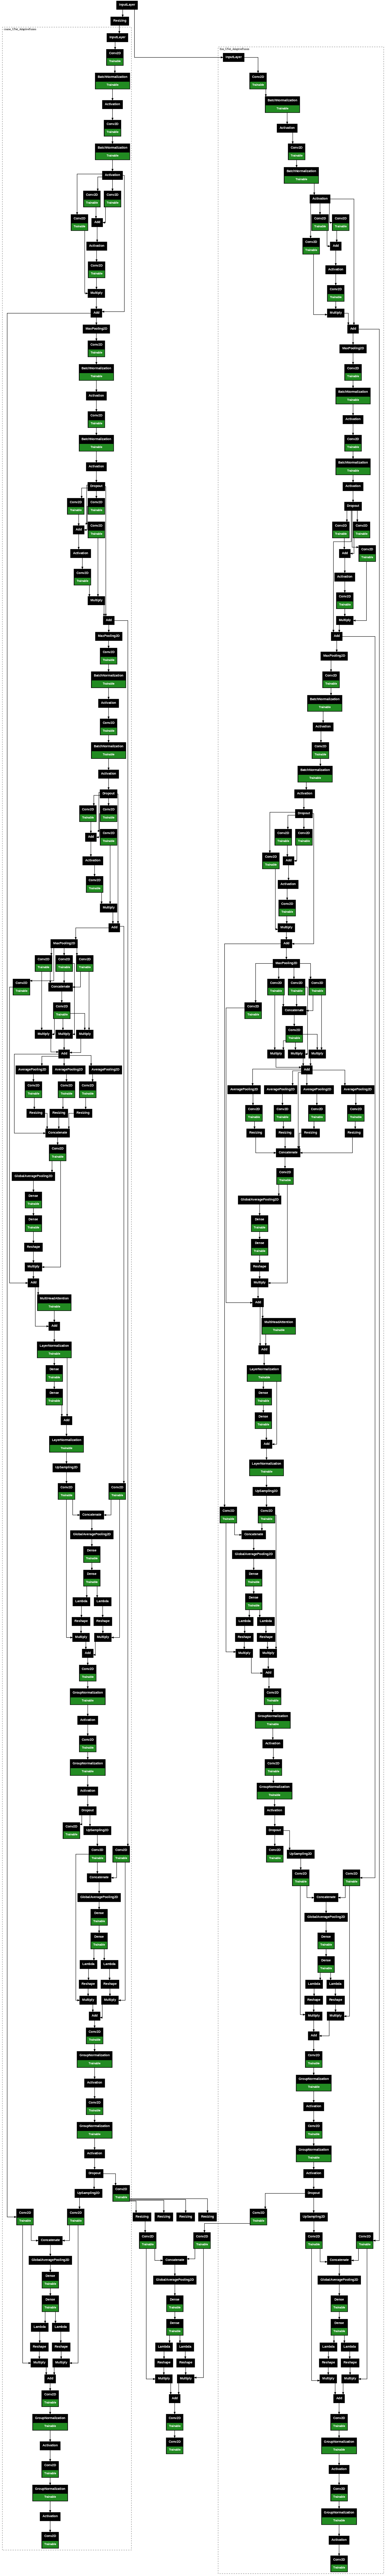

In [ ]:
model = get_dual_unet_model_with_supervision()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

### Loss definitions

In [ ]:
# Load the NumPy array which extracts labels from the train_dataset
all_labels = np.load('../Dataset/all_labels.npy')

In [ ]:
# Get unique classes and compute class weights
classes = np.unique(all_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=all_labels)

# Convert class weights to TensorFlow-friendly format
alpha = tf.constant(class_weights, dtype=tf.float32)

# Function to compute boundary maps
def compute_boundary_map(y, num_classes):
    y_one_hot = tf.one_hot(tf.cast(y[..., 0], tf.int32), depth=num_classes)
    y_boundary = tf.image.sobel_edges(y_one_hot)  # Sobel edge detection
    y_boundary = tf.reduce_max(tf.abs(y_boundary), axis=-1)  # Combine x and y gradients
    return y_boundary

def boundary_loss(y_true, y_pred):
    num_classes = y_pred.shape[-1]

    # Compute boundary maps
    y_true_boundary = compute_boundary_map(y_true, num_classes)
    y_pred_boundary = compute_boundary_map(tf.argmax(y_pred, axis=-1)[..., tf.newaxis], num_classes)

    # L2 loss between boundary maps
    return tf.reduce_mean(tf.square(y_true_boundary - y_pred_boundary))

focal_loss = tf.keras.losses.CategoricalFocalCrossentropy(
    alpha=alpha,
    gamma=2.0,
    from_logits=False,
    reduction='sum_over_batch_size',
    name='categorical_focal_crossentropy'
)

dice_loss = tf.keras.losses.Dice(
    reduction='sum_over_batch_size',
    name='dice'
)

cross_entropy_loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='sum_over_batch_size',
    name='sparse_categorical_crossentropy'
)

# Combined Loss Function
def combined_loss(y_true, y_pred):
    # Convert y_true to one-hot format for focal loss
    num_classes = y_pred.shape[-1]  # Extract number of classes
    y_true_one_hot = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=num_classes)  # One-hot encoding

    # Sparse Categorical Crossentropy
    ce = cross_entropy_loss(y_true, y_pred)

    # Dice Loss
    dice = dice_loss(y_true, y_pred)

    # Focal Loss
    focal = focal_loss(y_true_one_hot, y_pred)

    # Boundary Loss
    b_loss = boundary_loss(y_true, y_pred)

    # Weighted Combination
    return 0.4 * ce + 0.3 * dice + 0.2 * focal + 0.1 * b_loss

# Combined Loss Function for coarse
def combined_loss_for_coarse(y_true, y_pred):
    # Convert y_true to one-hot format for focal loss
    num_classes = y_pred.shape[-1]  # Extract number of classes
    y_true_one_hot = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=num_classes)  # One-hot encoding

    # Sparse Categorical Crossentropy
    ce = cross_entropy_loss(y_true, y_pred)

    # Dice Loss
    dice = dice_loss(y_true, y_pred)

    # Focal Loss
    focal = focal_loss(y_true_one_hot, y_pred)

    # Boundary Loss
    b_loss = boundary_loss(y_true, y_pred)

    # Weighted Combination
    return 0.1 * ce + 0.6 * dice + 0.3 * focal

# Combined Loss Function for fine
def combined_loss_for_fine(y_true, y_pred):
    # Convert y_true to one-hot format for focal loss
    num_classes = y_pred.shape[-1]  # Extract number of classes
    y_true_one_hot = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=num_classes)  # One-hot encoding

    # Sparse Categorical Crossentropy
    ce = cross_entropy_loss(y_true, y_pred)

    # Dice Loss
    dice = dice_loss(y_true, y_pred)

    # Focal Loss
    focal = focal_loss(y_true_one_hot, y_pred)

    # Boundary Loss
    b_loss = boundary_loss(y_true, y_pred)

    # Weighted Combination
    return 0.1 * ce + 0.3 * dice + 0.2 * focal + 0.4 * b_loss

*Our chioce:*

| Output Type       | Loss Combination                            |
|-------------------|---------------------------------------------|
| **Main Output**   | 0.4 `ce` + 0.3 `dice` + 0.2 `focal` + 0.1 `b_loss` |
| **Coarse Outputs**| 0.1 `ce` + 0.6 `dice` + 0.3 `focal`                |
| **Fine Outputs**  | 0.1 `ce` + 0.3 `dice` + 0.2 `focal` + 0.4 `b_loss` |

### Compile and train the model

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the stated[]
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)

            pred=pred[0]


            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = 5
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
print("Compiling model ...")
model.compile(
    #loss=combined_loss_with_dual_supervision,
    loss=[combined_loss, # main
          combined_loss_for_coarse,combined_loss_for_coarse,combined_loss_for_coarse, # coarse
          combined_loss_for_fine,combined_loss_for_fine,combined_loss_for_fine], # fine
    loss_weights = [0.5,0.1,0.1,0.1,0.15,0.15,0.15],
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE),
    metrics=[
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for the main output
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 3
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]  # Metrics for fine output 3
    ]
)
print("Model compiled!")

Compiling model ...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_final_output_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(val_img[0], val_lbl[0])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=5e-6, verbose=1)

In [ ]:
def warmup_schedule(epoch, lr, warmup_epochs=5, initial_lr=1e-5, target_lr=1e-3):
    if epoch < warmup_epochs:
        return initial_lr + (target_lr - initial_lr) * (epoch / warmup_epochs)
    else:
        return target_lr

warmup_callback = tf.keras.callbacks.LearningRateScheduler(warmup_schedule)

In [ ]:
warmup_epochs = 5
total_epochs = 50
initial_lr = 1e-3

def combined_schedule(epoch, lr, warmup_epochs=5, total_epochs=50, initial_lr=1e-5, target_lr=1e-3):
    if epoch < warmup_epochs:
        # Warm-up phase
        lr = initial_lr + (target_lr - initial_lr) * (epoch / warmup_epochs)
    else:
        # Cosine annealing phase
        cosine_decay = 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
        lr = target_lr * cosine_decay
    return float(lr)  # Ensure the result is a Python float

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(combined_schedule)


In [ ]:
def one_cycle_schedule(epoch, lr, max_lr=1e-3, total_epochs=50):
    half_epoch = total_epochs // 2
    if epoch < half_epoch:
        return lr + (max_lr - lr) * (epoch / half_epoch)
    else:
        return max_lr - (max_lr - lr) * ((epoch - half_epoch) / half_epoch)

one_cycle_callback = tf.keras.callbacks.LearningRateScheduler(one_cycle_schedule)


In [ ]:
"""
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, one_cycle_callback],  # Use one-cycle policy
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_final_output_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")
"""

'\n# Train the model\nhistory = model.fit(\n    train_dataset,\n    epochs=EPOCHS,\n    validation_data=val_dataset,\n    callbacks=[early_stopping, viz_callback, one_cycle_callback],  # Use one-cycle policy\n    verbose=1\n).history\n\n# Calculate and print the final validation accuracy\nfinal_val_meanIoU = round(max(history[\'val_final_output_mean_iou\'])* 100, 2)\nprint(f\'Final validation Mean Intersection Over Union: {final_val_meanIoU}%\')\n\n# Save the trained model to a file with the accuracy included in the filename\ntimestep_str = datetime.now().strftime("%y%m%d_%H%M%S")\nmodel_filename = f"model_{timestep_str}.keras"\nmodel.save(model_filename)\ndel model\n\nprint(f"Model saved to {model_filename}")\n'

In [ ]:
# Train the model 2
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, lr_scheduler_callback],  # Use warm-up + cosine annealing
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_final_output_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")


In [ ]:
# Final validation Mean Intersection Over Union: 50.19%

### Accuracy and mean IoU plots

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['final_output_accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_final_output_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['final_output_mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_final_output_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model

In [ ]:
# Load UNet model without compiling
model = tfk.models.load_model(model_filename, compile=False) #compile false because I have a custom metric

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
     metrics=[
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for the main output
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 3
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]  # Metrics for fine output 3
    ]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
# model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
# tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

In [ ]:
def plot_triptychs(dataset, model, num_samples=1):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    """
    # Take samples from the dataset
    samples = dataset.take(num_samples)
    plot_count=0

    for images, labels in samples:
        # If we have a batch, take the first example
        #if len(images.shape) == 4:  # Batch of images
        #    images = images[0:1]
        #    labels = labels[0:1]


        # Generate predictions
        pred = model.predict(images, verbose=0)[0]
        pred = tf.math.argmax(pred, axis=-1)

        # Create colormap based on number of classes in labels
        labels_np = labels.numpy()
        #num_classes = len(np.unique(labels_np))
        num_classes= 5
        colormap = create_segmentation_colormap(num_classes)


        for i in range(images.shape[0]):
            if plot_count >= num_samples:
                break  # Stop if we've plotted enough samples

            # Create figure with subplots
            fig, axes = plt.subplots(1, 3, figsize=(10, 3))

            # Plot original image
            axes[0].set_title("Original Image")
            axes[0].imshow(images[i], cmap='gray')
            axes[0].axis('off')

            # Plot original mask
            axes[1].set_title("Original Mask")
            colored_label = apply_colormap(labels[i], colormap)
            axes[1].imshow(colored_label)
            axes[1].axis('off')

            # Plot predicted mask
            axes[2].set_title("Predicted Mask")
            colored_pred = apply_colormap(pred[i], colormap)
            axes[2].imshow(colored_pred)
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

            plot_count += 1  # Increment plot counter

# Example usage:
# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=3)

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename,compile=False)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
     metrics=[
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for the main output
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 3
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]  # Metrics for fine output 3
    ]
)

print(f"Model loaded from {model_filename}")

Model loaded from model_241211_114739.keras


In [ ]:
X_test = X_test / 255.0
X_test = X_test.astype(np.float32)

# Define prediction batch size
prediction_batch_size = 1024

# Initialize a list to store predictions
all_preds = []

# Predict in batches
for i in range(0, len(X_test), prediction_batch_size):
    # Select the batch
    X_batch = X_test[i:i + prediction_batch_size]

    # Make predictions for the current batch
    batch_preds = model.predict(X_batch)[0]  # Only take the final predictions

    # Convert to class labels
    batch_preds = np.argmax(batch_preds, axis=-1)

    # Append to the list of predictions
    all_preds.append(batch_preds)

# Concatenate all predictions into a single array
all_preds = np.concatenate(all_preds, axis=0)

# Check final shape
print(f"Predictions shape: {all_preds.shape}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 527ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(all_preds)
submission_df.to_csv(submission_filename, index=False)

**Now, before running the following command, you have to download the `.csv` file from your Drive folder.**



In [ ]:
# Delete the created files on Drive (the submission csv is alreay in your local Download folder)
!rm model.png *.keras *.csv